### _Fruit Classification with PySpark and TensorFlow: Dimensionality Reduction for Deep Learning_

**Project Overview:** The project focuses on fruit classification using PySpark for distributed data processing and TensorFlow for deep learning-based image classification. The goal is to classify fruit images into different categories and gain insights from the data.

**Table of Contents:**

1.  **Data Loading and Preprocessing**
    
    *   Reading image data with PySpark.
    *   Extracting labels from file paths.
    *   Initial data exploration.
2.  **Data Transformation and Dimensionality Reduction**
    
    *   Preparing the data for dimensionality reduction.
    *   Implementing dimensionality reduction techniques (e.g., PCA) using PySpark.
3.  **Deep Learning Model Development **
    
    *   Creating a deep learning model using TensorFlow.
    *   Training the model on the reduced data.
4.  **Integration of Dimensionality Reduction with Model**
    
    *   Combining the dimensionality-reduced data with the deep learning model.
5.  **Fruit Classification**
    
    *   Running fruit classification on the integrated model.

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

2023-11-28 14:48:22.640677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/ismailcanoguz/Desktop/project7
PATH_Data:   /Users/ismailcanoguz/Desktop/project7/data/Test1
PATH_Result: /Users/ismailcanoguz/Desktop/project7/data/Results


In [3]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 14:48:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [4]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [5]:
spark

In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [8]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------------+----------+
|path                                                                          |label     |
+------------------------------------------------------------------------------+----------+
|file:/Users/ismailcanoguz/Desktop/project7/data/Test1/Watermelon/r_106_100.jpg|Watermelon|
|file:/Users/ismailcanoguz/Desktop/project7/data/Test1/Watermelon/r_109_100.jpg|Watermelon|
|file:/Users/ismailcanoguz/Desktop/project7/data/Test1/Watermelon/r_108_100.jpg|Watermelon|
|file:/Users/ismailcanoguz/Desktop/project7/data/Test1/Watermelon/r_107_100.jpg|Watermelon|
|file:/Users/ismailcanoguz/Desktop/project7/data/Test1/Watermelon/r_95_100.jpg |Watermelon|
+-----------------------------------------------------

In [9]:
images.show()

+--------------------+-------------------+------+--------------------+----------+
|                path|   modificationTime|length|             content|     label|
+--------------------+-------------------+------+--------------------+----------+
|file:/Users/ismai...|2021-09-12 19:25:42|  7353|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7350|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7349|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7348|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7328|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7301|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7278|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7275|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ismai...|2021-09-12 19:25:42|  7266|[FF D8 FF E0 00 1...|Watermelon|
|file:/Users/ism

In [10]:
images.groupBy('label').count().orderBy(col("count").desc()).show(131)

+-------------------+-----+
|              label|count|
+-------------------+-----+
|         Grape Blue|  328|
|             Plum 3|  304|
|             Walnut|  249|
|   Strawberry Wedge|  246|
| Melon Piel de Sapo|  246|
|           Tomato 1|  246|
|           Tomato 3|  246|
|           Cherry 2|  246|
|     Cherry Rainier|  246|
|            Peach 2|  246|
|         Pear Stone|  237|
|        Cauliflower|  234|
|       Pear Forelle|  234|
|      Pepper Orange|  234|
|                Fig|  234|
|             Pear 2|  232|
|       Tomato Heart|  228|
|           Tomato 2|  225|
|           Pear Red|  222|
|      Pepper Yellow|  222|
|         Pepper Red|  222|
| Apple Red Yellow 2|  219|
|         Nut Forest|  218|
|          Nut Pecan|  178|
|          Raspberry|  166|
|          Pineapple|  166|
|             Lychee|  166|
|          Mandarine|  166|
|              Limes|  166|
|              Cocos|  166|
|         Clementine|  166|
|              Guava|  166|
|        Huckleberry

In [11]:
images = images.withColumn("category", split(col("label"), " ")[0])

In [12]:
images.groupBy('category').count().orderBy(col("count").desc()).show(67)

+-----------+-----+
|   category|count|
+-----------+-----+
|      Apple| 2134|
|     Tomato| 1707|
|       Pear| 1689|
|     Cherry| 1148|
|      Grape| 1146|
|     Pepper|  826|
|     Potato|  601|
|       Plum|  597|
|      Peach|  574|
|     Banana|  484|
|      Onion|  451|
| Strawberry|  410|
|        Nut|  396|
| Grapefruit|  330|
|      Lemon|  330|
|  Pineapple|  329|
| Cantaloupe|  328|
|   Physalis|  328|
|  Nectarine|  324|
|    Avocado|  309|
|      Mango|  308|
|       Corn|  304|
|   Cucumber|  286|
|     Walnut|  249|
|      Melon|  246|
|Cauliflower|  234|
|        Fig|  234|
|  Raspberry|  166|
|     Lychee|  166|
|  Mandarine|  166|
|      Limes|  166|
|      Cocos|  166|
| Clementine|  166|
|      Guava|  166|
|Huckleberry|  166|
|    Tangelo|  166|
|   Pitahaya|  166|
|  Carambula|  166|
|   Maracuja|  166|
|     Quince|  166|
|    Passion|  166|
|       Kaki|  166|
|      Dates|  166|
|   Kumquats|  166|
|  Tamarillo|  166|
| Granadilla|  166|
|     Pepino|  166|


In [13]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [14]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [15]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [16]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [17]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [18]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/ismailcanoguz/opt/anaconda3/envs/can/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [19]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [20]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [21]:
print(PATH_Result)

/Users/ismailcanoguz/Desktop/project7/data/Results


<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [22]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-11-28 14:51:16.705671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
35/35 [==============================] - 24s 645ms/step
/Users/ismailcanoguz/opt/anaconda3/envs/can/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
35/35 [==============================] - 22s 600ms/step


In [23]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 10 premières lignes du DataFrame</u> :

In [24]:
df.head(10)

,path,label,features
0,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.15326513, 0.44225603, 0.0, 0.056561857, 0.9..."
1,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.18860456, 0.3506741, 0.066527545, 0.0, 0.64..."
2,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.71647334, 0.29308358, 0.0, 0.06521502, 0.57..."
3,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pineapple Mini,"[0.0, 4.5104938, 0.0, 0.012637333, 0.007268711..."
4,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.16856913, 0.27459854, 0.0, 0.0, 3.2491817, ..."
5,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pineapple Mini,"[0.0, 4.735071, 0.0, 0.0, 0.0, 0.0, 0.27112657..."
6,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pineapple Mini,"[0.0, 4.5664067, 0.00800124, 0.0, 0.044815805,..."
7,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pineapple Mini,"[0.0, 4.371608, 0.0, 0.0, 0.0, 0.0, 0.38634482..."
8,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.13633409, 0.20998523, 0.0, 0.0, 2.0144188, ..."
9,file:/Users/ismailcanoguz/Desktop/project7/dat...,Cucumber Ripe,"[1.7044764, 0.015616115, 0.0, 0.0, 0.0, 0.0, 2..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [25]:
df.loc[0,'features'].shape

(1280,)

In [26]:
df['category'] = df['label'].apply(lambda x: x.split(' ')[0])

In [28]:
df

,path,label,features,category
0,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.15326513, 0.44225603, 0.0, 0.056561857, 0.9...",Watermelon
1,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.18860456, 0.3506741, 0.066527545, 0.0, 0.64...",Watermelon
2,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.71647334, 0.29308358, 0.0, 0.06521502, 0.57...",Watermelon
3,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pineapple Mini,"[0.0, 4.5104938, 0.0, 0.012637333, 0.007268711...",Pineapple
4,file:/Users/ismailcanoguz/Desktop/project7/dat...,Watermelon,"[0.16856913, 0.27459854, 0.0, 0.0, 3.2491817, ...",Watermelon
...,...,...,...,...
22683,file:/Users/ismailcanoguz/Desktop/project7/dat...,Banana,"[0.78466815, 0.051888846, 0.0, 0.024591941, 0....",Banana
22684,file:/Users/ismailcanoguz/Desktop/project7/dat...,Banana,"[0.16657072, 0.4177556, 0.0, 0.0, 0.37848893, ...",Banana
22685,file:/Users/ismailcanoguz/Desktop/project7/dat...,Banana,"[0.0143129, 0.13484085, 0.0, 0.0, 0.6788137, 0...",Banana
22686,file:/Users/ismailcanoguz/Desktop/project7/dat...,Banana Lady Finger,"[0.05408794, 0.0, 0.34598672, 0.0, 1.4277601, ...",Banana


In [87]:
import random

all_categories = df['category'].unique()

# Convert the NumPy array to a list
all_categories_list = all_categories.tolist()

# Choose six random categories from the unique categories
chosen_categories = random.sample(all_categories_list, 8)



# Subsample the dataframe
subsampled_df = df[df['category'].isin(chosen_categories)]

display(subsampled_df)



,path,label,features,category
72,file:/Users/ismailcanoguz/Desktop/project7/dat...,Nectarine,"[0.3415418, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4010592...",Nectarine
78,file:/Users/ismailcanoguz/Desktop/project7/dat...,Nectarine,"[0.14966069, 0.012309415, 0.0, 0.0, 0.0, 0.025...",Nectarine
84,file:/Users/ismailcanoguz/Desktop/project7/dat...,Cantaloupe 1,"[0.053621177, 0.0, 0.0, 0.0, 0.0, 0.19985254, ...",Cantaloupe
85,file:/Users/ismailcanoguz/Desktop/project7/dat...,Cantaloupe 2,"[0.21561661, 0.0, 0.0, 0.0, 0.020269569, 0.0, ...",Cantaloupe
86,file:/Users/ismailcanoguz/Desktop/project7/dat...,Cantaloupe 1,"[0.0021931103, 0.0, 0.0, 0.0, 0.0, 0.26058042,...",Cantaloupe
...,...,...,...,...
22552,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pepino,"[0.012436127, 0.26940146, 0.0, 0.0, 0.06698764...",Pepino
22601,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pepino,"[0.08804677, 0.1423481, 0.0, 0.0, 0.35472745, ...",Pepino
22605,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pepino,"[0.0, 0.19326186, 0.0, 0.0, 0.15954822, 0.2310...",Pepino
22614,file:/Users/ismailcanoguz/Desktop/project7/dat...,Pepino,"[0.002867329, 0.12269707, 0.0, 0.0, 0.38618764...",Pepino


In [88]:
features = pd.DataFrame(subsampled_df['features'].values.tolist(), index= subsampled_df.index)


In [77]:


# Add category
tsne_df['category'] = subsampled_df['category']

In [78]:
tsne_df['category']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3748    NaN
3749    NaN
3750    NaN
3751    NaN
3752    NaN
Name: category, Length: 3753, dtype: object

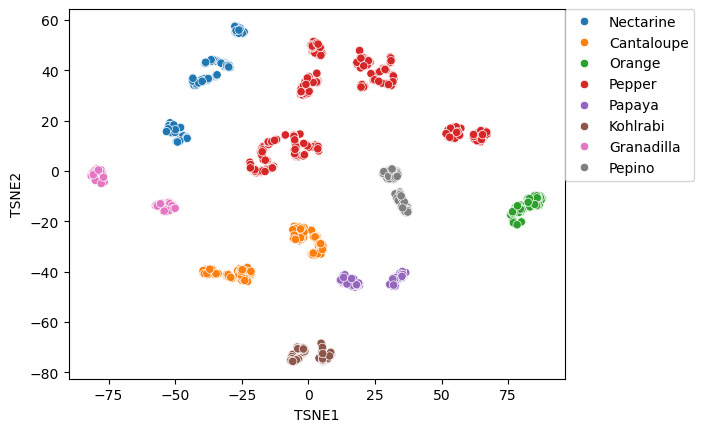

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE(n_components=2, perplexity=50, n_iter=5000, init='random', random_state=1944).fit_transform(features), columns=['TSNE1', 'TSNE2'])

# Reset the index of subsampled_df
subsampled_df_reset = subsampled_df.reset_index(drop=True)

# Add category
tsne_df['category'] = subsampled_df_reset['category']

# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='category')
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.show()



,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60
0,-6.914188,8.045402,2.696595,-1.347698,1.269910,1.869238,1.140106,-1.947119,-1.155887,2.694731,...,0.068095,0.702046,-1.038579,0.356294,0.169226,-0.232271,0.815245,-0.406374,-0.229474,0.105116
1,-6.872915,10.778125,2.459239,-5.334941,3.183956,2.170031,3.778660,-2.353213,1.865156,3.120608,...,-0.633747,-0.098665,0.691355,0.236365,0.336375,-0.657777,0.651530,0.055352,-0.059702,-0.390993
2,-8.390913,-4.177805,-6.362139,-1.000927,-0.958214,-4.552357,3.674216,-1.177786,0.152536,-1.271256,...,0.058357,0.193952,-1.228566,0.398153,-0.033714,-0.285473,-0.506657,-0.475153,0.533583,-0.266746
3,-10.112303,-10.061602,-2.528583,-3.693007,-1.034283,4.663967,-3.084735,0.840739,2.609930,-0.432648,...,-0.041358,0.964828,-0.156136,1.028660,0.790610,-0.098089,0.478354,-0.375496,-0.383622,2.600355
4,-8.473356,-4.257480,-6.501722,-2.039944,-1.210238,-3.958547,3.873148,-0.743961,-0.300318,-1.206783,...,0.508905,0.095435,-0.903430,0.622910,-0.255099,-0.297183,-0.195355,-0.200124,-0.053393,-0.763088


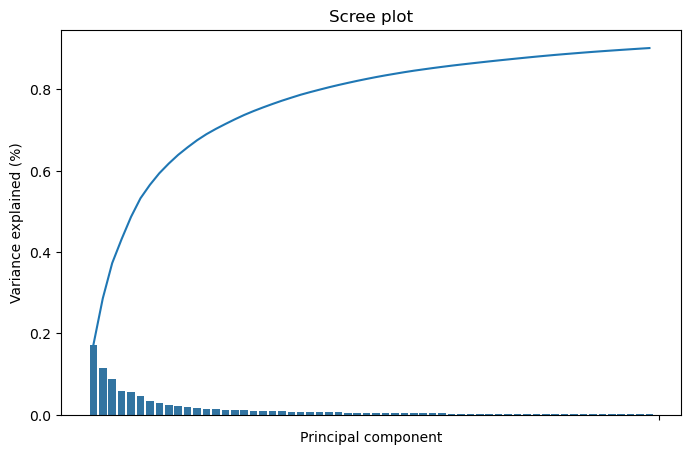

In [98]:
from sklearn.decomposition import PCA


# Number of components
PCA_K = 60

# Create PCA model
pca = PCA(n_components=PCA_K)

# Fit to data
pca_data = pca.fit_transform(features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])

# Display the first few rows of the PCA DataFrame
display(pca_df.head())

# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display scree plot
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()


In [99]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

# Show max component
print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(pca_evr_cumsum[PCA_K-1], PCA_K, pca_evr_cumsum[PCA_K-1]))


80% of the variance is explained by 26 principal components (0.8045)
85% of the variance is explained by 37 principal components (0.8516)
90% of the variance is explained by 60 principal components (0.9008)
90% of the variance is explained by 60 principal components (0.9008)
